## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.stats
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# ax = [None] * 13
# fig, (ax[0], ax[1], ax[2], ax[3], ax[4],
#       ax[5], ax[6], ax[7], ax[8], ax[9],
#       ax[10], ax[11], ax[12]) = plt.subplots(nrows=13, figsize=(15,40))
# plot_count = 0

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    pbar = tqdm(list(zip(data_fls, ref_fls)))
    for data_fl, ref_fl in pbar:
        pbar.set_description("{} and {}".format(data_fl.split('/')[-1], ref_fl.split('/')[-1]))
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
#         break
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def plot_2d(m, title=""):
    """ A simple little 2D matrix plotter, excluding x and y labels. """
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
class Log():
    def __init__(self):
        pass
    
log = Log()

def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        
def BandpassFilteringStep(signals, low=0.4, high=5, freq=125):
    signals_f = signals.copy()
    for i, sig in enumerate(signals):
#         ax[i].plot(sig)
        signals_f[i, :] = BandpassFilter(sig, (low, high), freq)
#         ax[i].plot(signals_f[i])
    return signals_f
        
def SignalDecompositionStep(signals, freq=125, L=400):
    for i, sig in enumerate(signals):
        sig_ssa = SSA(sig, L)
#         log.sig_ssa = sig_ssa
        
    return None

def TemporalDifferenceStep(signals):
    return signals

def SSRStep(signals):
    return signals

def SpectrumPeakTrackingStep(signals):
    return signals

def EstimateHR(signals, prev_est=None, freq=125, L=400):
#     signals = BandpassFilteringStep(signals, freq=freq)
    signals = SignalDecompositionStep(signals, freq=freq, L=L)
#     signals = TemporalDifferenceStep(signals)
#     signals = SSRStep(signals)
#     est, features = SpectrumPeakTrackingStep(signals)
    features = None
    est = None
    return (est, features)

def Confidence(est, features, freq=125):
    global plot_count, cmap


    # Prepare the spectogram
    f, t, Sxx = scipy.signal.spectrogram(features, freq, window=sp.signal.hann(freq))
#     print(f)
#     print(np.round(est))

#     ax[1].plot(ecg)
#     ax[2].pcolormesh(t, f, Sxx)
    
    # Maximum confidence throughout all frequencies
    max_conf = np.max(np.sum(Sxx, axis=1)) / np.sum(Sxx)
#     print("Max Confidence: {}".format(max_conf))

    conf = np.sum(Sxx[int(np.round(est)), :]) / np.sum(Sxx)
#     print("Confidence: {}".format(conf))
    return np.sum(Sxx[int(np.round(est)), :]) / np.sum(Sxx)
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """ Running Pulse Rate Algorithm
    """
    
    # Frequency of the signals sampled in Hertz.
    # For example, 125 means there are 125 samples every second.
    sig_freq = 125 # Hertz
    
    # Each reference pulse rate is calculated from this many seconds.
    ref_t = 8 # seconds
    
    # Time difference (in seconds) between one time window and the next.
    ref_s = 2 # seconds
    
    # Load data using scipy. "scipy.io.loadmat(f)"
    sig = scipy.io.loadmat(data_fl)['sig']
    ref = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    ref_bps = ref / 60.0
#     print(sig[0, 0:sig_freq*8])
#     print(np.sum(sig[0, 0:sig_freq*8]))
#     print(ref[0])
#     print("\n")

    # Get all starting ids
    start_idxs = (np.cumsum(np.ones(len(ref)) * sig_freq * ref_s) - sig_freq * ref_s).astype(int)
    train = sig[1:, :]
#     print(start_idxs)
#     print(len(start_idxs))


    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(len(ref)), np.ones(len(ref))
    prev_est = None
    
    # Signals Preprocessing
    # ---------------------
    # Perform bandpass filtering on both PPG and acceleration signals.
    train = BandpassFilteringStep(train, freq=sig_freq)
    
    # Decompose PPG signals
#     ppg = SignalDecompositionStep(train[0:2, :], freq=sig_freq)
#     print(train[0:2, :].shape)
    # ---------------------

    # Compute pulse rate estimates and estimation confidence.
    for i, start_idx in enumerate(tqdm(start_idxs, desc='Estimate HR')):
        end_idx = start_idx+ref_t*sig_freq
        # Make sure we have enough data left
        if end_idx <= sig.shape[1]:
#             print("from {} to {}".format(start_idx, end_idx))
            train_i = train[:, start_idx:end_idx]
            prev_est, features = EstimateHR(train_i, prev_est, freq=sig_freq, L=20)
        
            # Use result as estimation and ecg as features, for analysis
            prev_est = ref_bps[i]
            features = sig[0, start_idx:end_idx]
            
#             confidence[i] = Confidence(prev_est, features)
            log.ref_i = ref[i]
            log.prev_est = prev_est
            log.train_i = train_i
            log.features = features
            log.ecg = sig[0, start_idx:end_idx]
#             print(log.ecg)
            
#             raise Exception
            
            confidence[i] = Confidence(prev_est, features, freq=sig_freq)
            errors[i] = np.abs(prev_est - ref[i])
    
    return errors, confidence


%timeit -n 1 -r 1 Evaluate()

KeyboardInterrupt: 

Ground Truth: 76.35746606334841 BPM
For 8 seconds: 10.180995475113122 beats
10.917048035451579


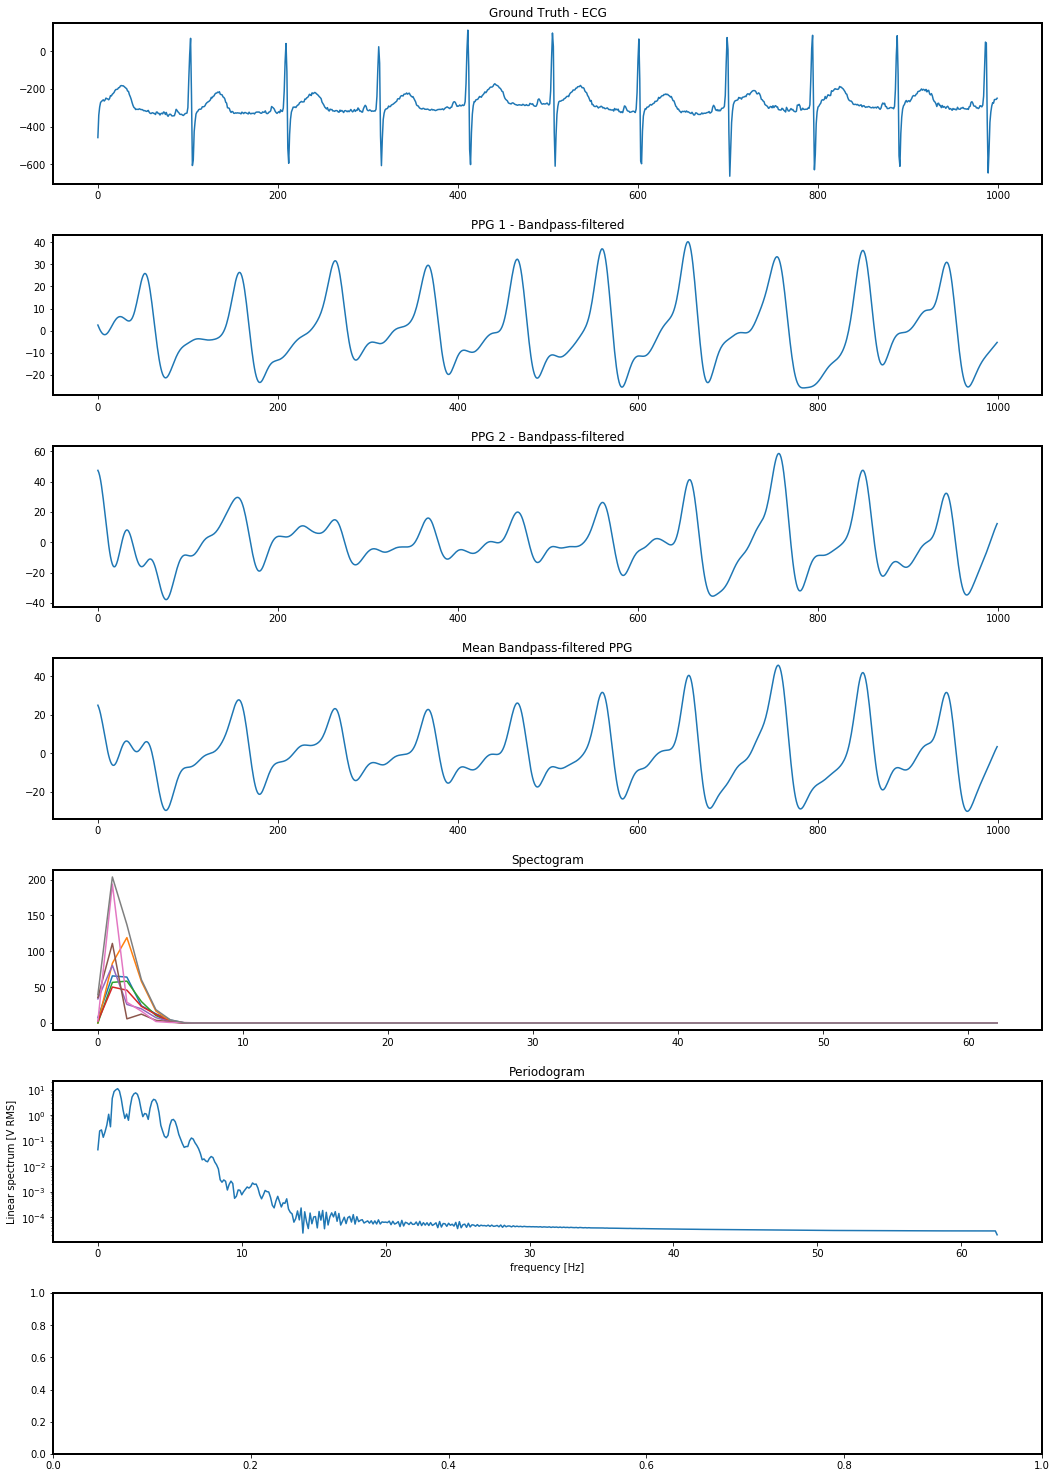

In [6]:


print("Ground Truth: {} BPM".format(log.ref_i))
print("For 8 seconds: {} beats".format(log.ref_i / 60 * 8))
ecg = log.ecg
sig = log.train_i
numplots = 7
ax = [None] * numplots
fig, ax = plt.subplots(nrows=numplots, figsize=(15,numplots * 3))
fig.tight_layout(pad=3.0)

ax[0].plot(ecg)
ax[0].set_title('Ground Truth - ECG')
ax[1].plot(sig[0, :])
ax[1].set_title('PPG 1 - Bandpass-filtered')
ax[2].plot(sig[1, :])
ax[2].set_title('PPG 2 - Bandpass-filtered')

features = np.mean(sig[0:2, :], axis=0)
ax[3].plot(features)
ax[3].set_title('Mean Bandpass-filtered PPG')

f, t, Sxx = scipy.signal.spectrogram(features, 125, window=scipy.signal.hann(125))
ax[4].plot(Sxx)
ax[4].set_title('Spectogram')

f, Pxx_spec = scipy.signal.periodogram(features, 125, 'flattop', scaling='spectrum')
ax[5].semilogy(f, np.sqrt(Pxx_spec))
ax[5].set_xlabel('frequency [Hz]')
ax[5].set_ylabel('Linear spectrum [V RMS]')
ax[5].set_title('Periodogram');
print(np.sqrt(Pxx_spec.max()))

# ax[4].plot(sig[2, :])
# ax[5].plot(sig[3, :])
# ax[6].plot(sig[4, :]);

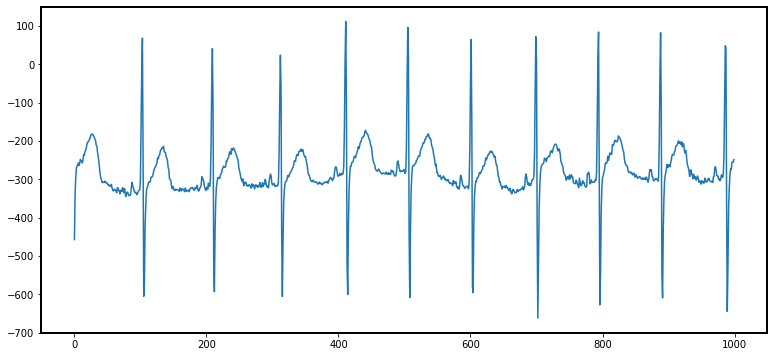

In [18]:
# Interactive plot, but can only display one plot at a time.
import mpld3
mpld3.enable_notebook()
plt.figure(figsize=(13,6))
plt.plot(ecg)

In [23]:
Pxx_spec.shape

(501,)

In [ ]:
sig_ssa = log.sig_ssa
# sig_ssa.plot_wcorr()
# plt.title("W-Correlation for Toy Time Series, $L=20$");

sig_ssa.reconstruct(0).plot()
sig_ssa.reconstruct([1,2,3]).plot()
sig_ssa.reconstruct(slice(4,20)).plot()
sig_ssa.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=400$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);


In [ ]:
x.shape

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...


### References

- Signal Processing basics: https://allsignalprocessing.com/introductory-content/
- Code for BandpassFilter: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
- Code for SSA: https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 